In [2]:
# Fill in your name using the format below and student ID number
your_name = "Wijnands, Yorick"
student_id = "0872208"

In [3]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = True

In [4]:
# Uncomment the following line to run in Google Colab
# !pip install --quiet openml 

In [5]:
# Uncomment the following line to run in Google Colab
#%tensorflow_version 2.x
import tensorflow as tf

conf =  tf.compat.v1.ConfigProto()
conf.gpu_options.allow_growth=True
session = tf.compat.v1.Session(config=conf)


In [6]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [7]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Hi Yorick, Looks good. You may continue :)


# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [8]:
#base_dir = '/content/drive/My Drive/TestAssignment' # For Google Colab
base_dir = './'

In [9]:
#Uncomment to link Colab notebook to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [10]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
#import os
#oml.config.cache_directory = os.path.expanduser('/content/cache')

In [11]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [12]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)

In [13]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

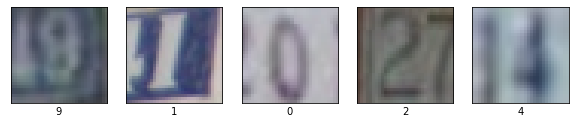

In [14]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [221]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow
from tensorflow.keras.models import model_from_json

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
        base_dir -- Directory where the models are stored
        name -- Name of the model, e.g. 'question_1_1'
        extension -- the file extension
    """
    try:
        # if a json description is available, load config and then weights
        if os.path.isfile(os.path.join(base_dir, name+'.json')):
            json_file = open(os.path.join(base_dir, name+'.json'), 'r')
            loaded_model_json = json_file.read()
            json_file.close()
            model = model_from_json(loaded_model_json)
            model.load_weights(os.path.join(base_dir, name+extension))
        # else just load the entire model from hdf5 file
        else:
            model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
        model -- the model to be saved
        base_dir -- Directory where the models should be stored
        name -- Name of the model, e.g. 'question_1_1'
        extension -- the file extension
    """
    path = os.path.join(base_dir, name+extension)
    model.save(path)
    size = os.path.getsize(path)
    # If model > 100MB, store the weights and architecture only.
    if size > 100*1024*1024:
        print("Model larger than 100MB, storing weights only.")
        model.save_weights(path)
        model_json = model.to_json()
        with open(os.path.join(base_dir, name+".json"), "w") as json_file:
            json_file.write(model_json)

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=verbose, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=verbose, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
        shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

Loading model from file
Success!
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_38 (Reshape)         (None, 3072)              0         
_________________________________________________________________
dense_255 (Dense)            (None, 10)                30730     
_________________________________________________________________
dense_256 (Dense)            (None, 10)                110       
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  2.233234  0.190561  2.233105      0.190974
max  2.246961  0.190954  2.233180      0.190974


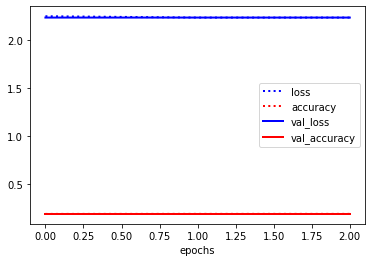

In [16]:
# Toy usage example
# Remove before submission
from tensorflow.keras import models
from tensorflow.keras import layers 

def build_toy_model():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# First build and store
run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, 
               train=False, epochs=3, batch_size=32)

Loading model from file
Success!
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_38 (Reshape)         (None, 3072)              0         
_________________________________________________________________
dense_255 (Dense)            (None, 10)                30730     
_________________________________________________________________
dense_256 (Dense)            (None, 10)                110       
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  2.233234  0.190561  2.233105      0.190974
max  2.246961  0.190954  2.233180      0.190974


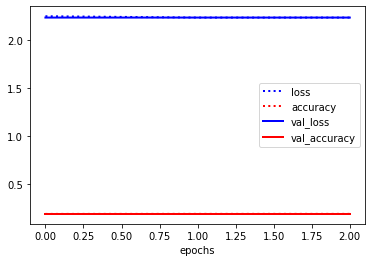

In [17]:
# Toy usage example
# Remove before submission
# With train=False: load from file and report the same results without rerunning
run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, 
               train=False)

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

Loading model from file
Success!
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              3146752   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)      

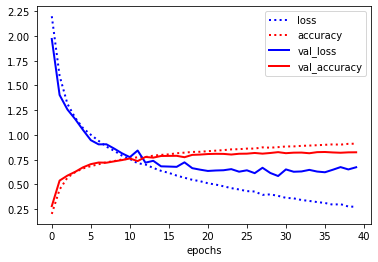

In [18]:
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))  
    model.add(layers.Dense(16, activation='relu'))    
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=optimizers.Adam(lr=4e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
              train=False, epochs=40, batch_size=128, verbose=1)

answer_q_1_1 = """
               We start with a high a amount of nodes and it gives the best result if we half it every time untill it is around the output layer.
               For the optimizer Adam give a bit better performance than RMSprop. Above 30 epochs the model really starts overfitting and the
               val_loss only increases, furthermore the val_accuracy doesn't improve much. The validation accuracy gives a pretty good performance.
               More layers with a lot of nodes gave the best result.
               """
print("Answer is {} characters long".format(len(answer_q_1_1)))

### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [19]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

Loading model from file
Success!
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)     

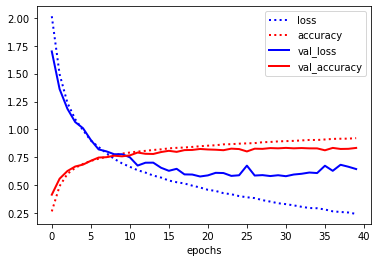

In [20]:
# Replace with the preprocessed data
preprocessed_split = rgb2gray(X_train), rgb2gray(X_val), y_train, y_val

# Adjusted model
def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))  
    model.add(layers.Dense(16, activation='relu'))    
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=optimizers.Adam(lr=4e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=False, epochs=40, batch_size=128)
answer_q_1_2 = """
               For this model the same model is used as in 1.1, however the iamges are replaced with grayscaled 
               versions. The color is probably not important to reconize the numbers 
               and it can avoid some false classification. When looking at the val_acc we can indeed see that it 
               indeed it performce better, altough just a bit.
               """
print("Answer is {} characters long".format(len(answer_q_1_2)))

### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

Loading model from file
Success!
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)  

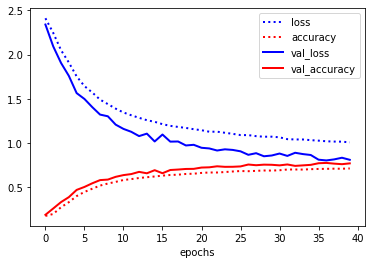

In [21]:
def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(1024, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(10, kernel_regularizer=regularizers.l2(0.0001), activation='softmax'))
    model.compile(optimizer=optimizers.Adam(lr=4e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=False, epochs=40, batch_size=128, verbose=1)

answer_q_1_3 = """
               Regularization decreases the performance of the model. With the kernel regularizer it decreases even more, also a higher dropout decreases it more.
               The val_loss still decreases, however when having even more epochs it does not decreases much more. The models in 1.1 and 1.2 were not really overfitting
               and thus regularize the model just makes it worse.
               """
print("Answer is {} characters long".format(len(answer_q_1_3)))

## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

Training the model
Train on 63544 samples, validate on 15887 samples
Epoch 1/10
63544/63544 [==============================] - 10s 160us/sample - loss: 1.3669 - accuracy: 0.5271 - val_loss: 0.7200 - val_accuracy: 0.8194
Epoch 2/10
63544/63544 [==============================] - 10s 159us/sample - loss: 0.5473 - accuracy: 0.8326 - val_loss: 0.4086 - val_accuracy: 0.8778
Epoch 3/10
63544/63544 [==============================] - 10s 154us/sample - loss: 0.4150 - accuracy: 0.8780 - val_loss: 0.3304 - val_accuracy: 0.8992
Epoch 4/10
63544/63544 [==============================] - 10s 155us/sample - loss: 0.3547 - accuracy: 0.8989 - val_loss: 0.2707 - val_accuracy: 0.9188
Epoch 5/10
63544/63544 [==============================] - 10s 151us/sample - loss: 0.3121 - accuracy: 0.9101 - val_loss: 0.2610 - val_accuracy: 0.9236
Epoch 6/10
63544/63544 [==============================] - 10s 157us/sample - loss: 0.2769 - accuracy: 0.9213 - val_loss: 0.2450 - val_accuracy: 0.9304
Epoch 7/10
63544/63544 [=

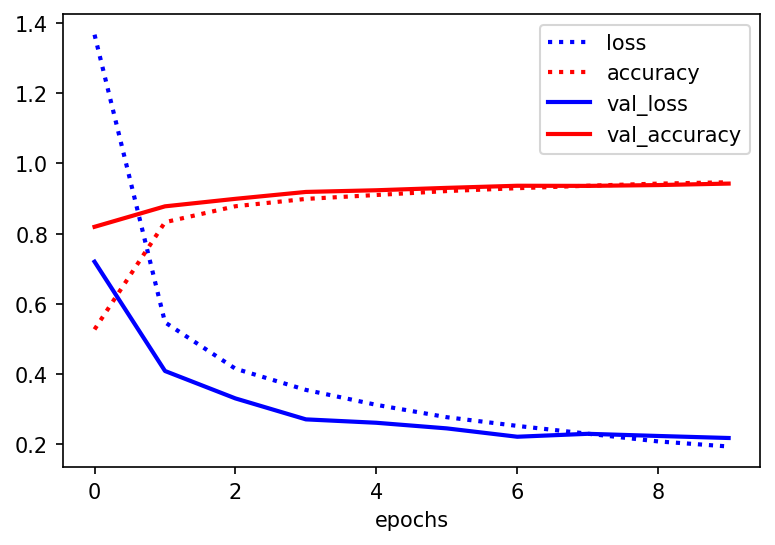

In [218]:
from tensorflow.keras import layers
from tensorflow.keras import models

def build_model_2_1():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                            input_shape=(32, 32, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer=optimizers.Adam(lr=4e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
    
run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=True, epochs=10, batch_size=128)

answer_q_2_1 = """
               We start with a 32 convalutional layer and increase it to 64 and 128. We add multiple layers such that we can extract 
               more features. We add more filter to try and capture a good amount of patters (for instance edges).
               MaxPooling is added to make hugely decrease the amount of weights and gives less overfitting, in this model it 
               dramatically decreases computation time and it gives a increase for the performance from the validation accuracy. 
               BatchNormaliztion slitly increases the performance. An dense layer is added after the flatten layer along with a 
               softmax model to the end to classify the image. For the optimizer the same one is used as in 1.1.
               """
print("Answer is {} characters long".format(len(answer_q_2_1)))

### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

63544 15887 63544 15887
[0.10987636]
Training the model
  ...
    to  
  ['...']
Train for 993 steps, validate on 15887 samples
Epoch 1/10
993/993 [==============================] - 13s 13ms/step - loss: 1.3270 - accuracy: 0.5468 - val_loss: 0.4535 - val_accuracy: 0.8613
Epoch 2/10
993/993 [==============================] - 13s 14ms/step - loss: 0.6045 - accuracy: 0.8146 - val_loss: 0.3361 - val_accuracy: 0.8981
Epoch 3/10
993/993 [==============================] - 12s 12ms/step - loss: 0.4523 - accuracy: 0.8674 - val_loss: 0.2943 - val_accuracy: 0.9129
Epoch 4/10
993/993 [==============================] - 13s 13ms/step - loss: 0.3753 - accuracy: 0.8927 - val_loss: 0.3077 - val_accuracy: 0.9059
Epoch 5/10
993/993 [==============================] - 13s 13ms/step - loss: 0.3256 - accuracy: 0.9095 - val_loss: 0.2254 - val_accuracy: 0.9364
Epoch 6/10
993/993 [==============================] - 12s 12ms/step - loss: 0.2949 - accuracy: 0.9190 - val_loss: 0.2247 - val_accuracy: 0.9375
Epoch 7/

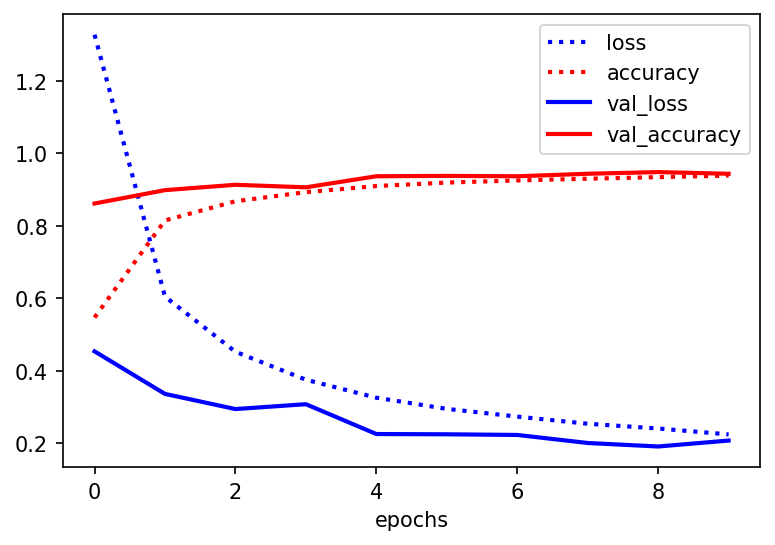

In [219]:
# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented
# data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(len(preprocessed_split[0]), len(preprocessed_split[1]), 
      len(preprocessed_split[2]), len(preprocessed_split[3]))

X_train_a, X_val_a, y_train_a, y_val_a = preprocessed_split

datagen = ImageDataGenerator(width_shift_range=0.1,
                              height_shift_range=0.1,
#                               rotation_range=10,
                              shear_range=0.1,
                              zoom_range=0.1,
                              )

data = datagen.flow(X_train_a, y_train_a, batch_size=64)
print(data[0][0][0][0][0])

augmented_split = data, X_val_a, y_val_a

run_evaluation("model_2_2", build_model_2_1, augmented_split, base_dir, 
               generator=True, train=True, epochs=10, batch_size=None, steps_per_epoch=993)

answer_q_2_2 = """
               Turning the pictures will decrease performance, because for example a six turned looks like a nine.
               The points in the image we want to fill work the best with the standard mode which looks at the nearest pixel.
               Bigger changes do not work well, smaller changes work better. When using some smaller changes, there
               is a little improvement on the validation data, however the training data does not improve.
               """
print("Answer is {} characters long".format(len(answer_q_2_2)))

## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

[32, 59, 257, 746, 759, 896, 914, 996, 1217, 1353, 1398, 1580, 1836, 1852, 1911, 2012, 2076, 2318, 2426]


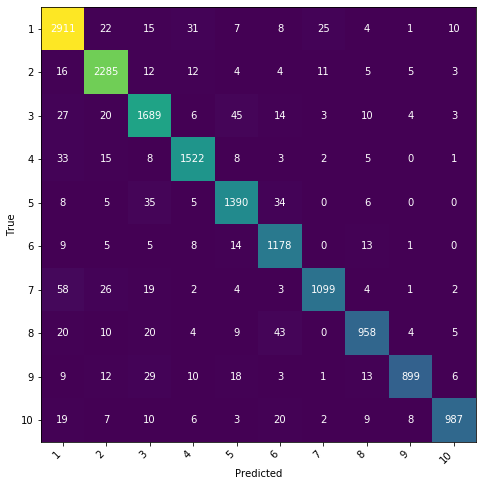

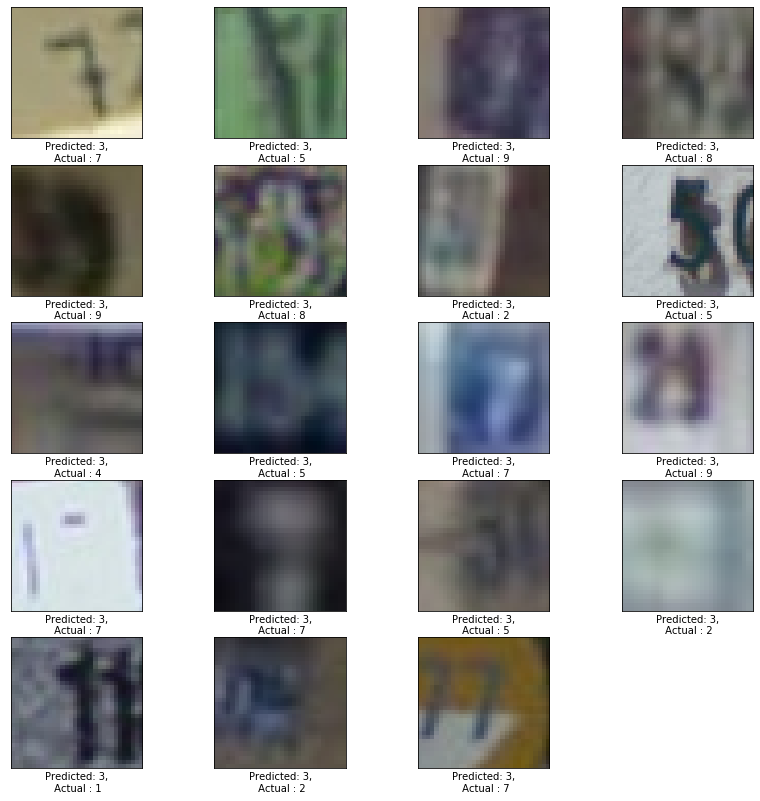

Answer is 361 characters long


In [44]:
from sklearn.metrics import confusion_matrix

test_accuracy_3_1 = 0

def plot_confusion_matrix():
    model = load_model_from_file(base_dir, 'model_2_2', extension='.h5')
    classes =  {0: "1", 1: "2", 2: "3", 3: "4", 4: "5",
                 5: "6", 6: "7", 7: "8", 8: "9", 9: "10"}
    y_pred = model.predict(X_val_a)
    cm = confusion_matrix(np.argmax(y_val_a, axis=1),np.argmax(y_pred, axis=1))
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm)
    ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
    ax.set_xticklabels(list(classes.values()), rotation=45, ha="right")
    ax.set_yticklabels(list(classes.values()))
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')  
    for i in range(100):
        ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", 
                color="w")
plot_confusion_matrix()
        
def plot_misclassifications():
    model = load_model_from_file(base_dir, 'model_2_2', extension='.h5')
    y_pred = model.predict(X_val_a)
    classes =  {0: "1", 1: "2", 2: "3", 3: "4", 4: "5",
                 5: "6", 6: "7", 7: "8", 8: "9", 9: "10"}
    misclassified_samples = np.nonzero(np.argmax(y_val_a, axis=1) != 
                                       np.argmax(y_pred, axis=1))[0]
    fig = plt.figure(figsize=(14, 14))
    samples = []
    count = 1
    for nr, i in enumerate(misclassified_samples) :
        if classes[np.argmax(y_pred[i])] is "3" and classes[np.argmax(y_val[i])] is not "3" and count < 20:
            count += 1
            samples.append(misclassified_samples[nr])
            
    print(samples)
    ax = []
    for nr, i in enumerate(samples) :
        ax.append(fig.add_subplot(5,4,nr+1))
        ax[-1].imshow(X_val[i])
        ax[-1].set_xlabel("Predicted: %s,\n Actual : %s" % 
                            (classes[np.argmax(y_pred[i])],
                             classes[np.argmax(y_val[i])]))
        ax[-1].set_xticks(()), ax[-1].set_yticks(())
            
            
    plt.show();

plot_misclassifications()

answer_q_3_1 = """
                
               When looking at the images, most images go wrong when there a multiple numbers in the picture. This could 
               be improved by even better augmenting the data and try as well as possible to get single numbers. Furthermore,
               some of the images are unreadable which make it hard to predict. Thus it mostly goes wrong with unclear images
               or images with multiple numbers.
               """
print("Answer is {} characters long".format(len(answer_q_3_1)))

### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

In [ ]:
from tensorflow.keras import models

model = load_model_from_file(base_dir, 'model_2_2', extension='.h5')

img = X_val_a[0]
img = np.expand_dims(img, axis=0) 

layer_outputs = [layer.output for layer in model.layers[:15]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img)

images_per_row = 16

layer_names = [3]
for layer in model.layers[:15]:
    layer_names.append(layer.name)
    
def plot_activation(layer_index, activations):
    start = layer_index
    end = layer_index+1
    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names[start:end], activations[start:end]):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title("Activation of layer {} ({})".format(layer_index+1,layer_name))
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()

def plot_activations():
    plot_activation(0, activations);
    plot_activation(2, activations);
    plot_activation(5, activations);
    plot_activation(7, activations);
    plot_activation(11, activations);
    plot_activation(12, activations);

    
plot_activations()
    
answer_q_3_2 = """
               In the first layer we still see the numbers, however we can see some of the edges being highlighted.
               In the next layers we see it becoming more abstract. In the last layer we can some highlights which
               cannot be seen in the training data. Thus it does indeed gets more abstract and it is learning
               something usefull.
               """
print("Answer is {} characters long".format(len(answer_q_3_2)))

### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

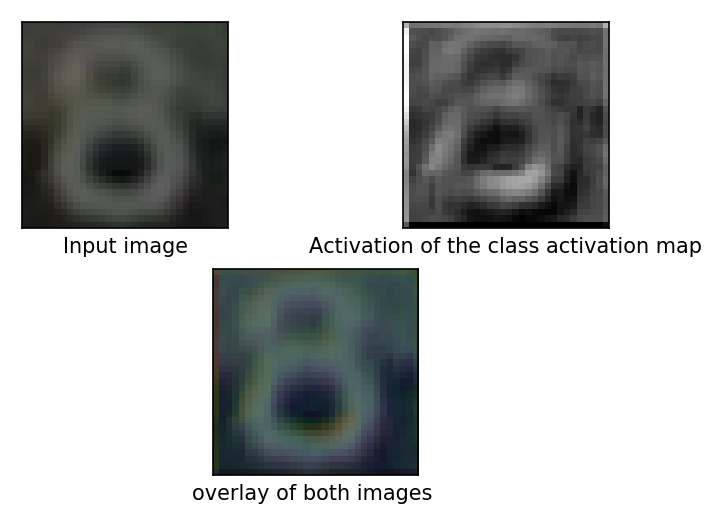

In [175]:
def plot_activation_map():
    
    import matplotlib.gridspec as gridspec

    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure()

    img = X_val_a[1]
    img = np.expand_dims(img, axis=0) 
    activation_3_3 = activation_model.predict(img)
    last_layer_activation = activation_3_3[1]

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])
    
    ax1.imshow(X_val[1])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_xlabel('Input image')
    ax2.matshow(last_layer_activation[0, :, :, 0], cmap='gray')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xlabel('Activation of the class activation map');
    ax3.imshow(X_val[1], interpolation='none', origin='lower', cmap='gray')
    ax3.imshow(last_layer_activation[0, :, :, 0], interpolation='none', alpha=0.1, cmap='jet')
    ax3.set_xlabel('overlay of both images ')
    ax3.set_xticks([])
    ax3.set_yticks([])
   
def plot_3_3():
    plot_activation_map()
    
plot_3_3()

## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

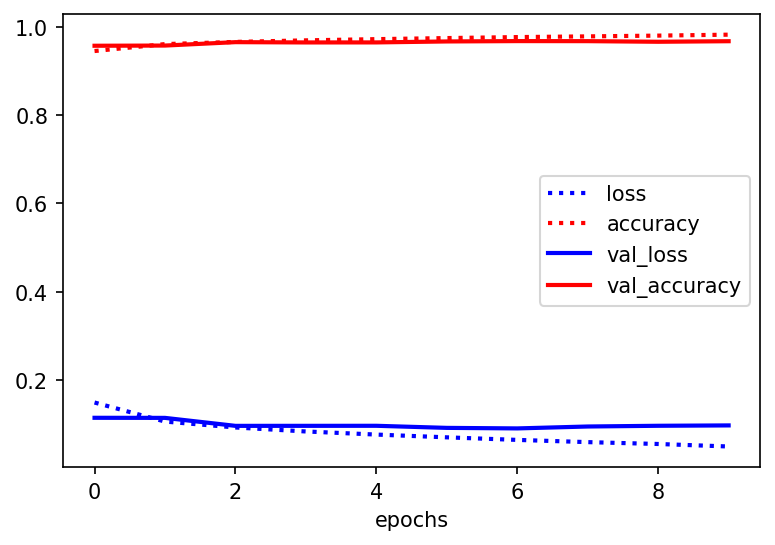

In [211]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def build_model_4_1():
    pretrained_model = VGG16(include_top=False, weights='imagenet',input_shape=(32, 32, 3))
    pretrained_model.summary()
    
    #lock all layers
#     for layer in model.layers:
#         layer.trainable = False
    count = 0
    
    #lock last few layers
    for layer in pretrained_model.layers:
        print(count)
        if count < 15:
            layer.trainable = False
            count += 1
        else:
            layer.trainable = True
            
    model = models.Sequential()
    model.add(pretrained_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.summary()
    
    model.compile(optimizer=optimizers.Adam(lr=4e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    
#     for i, layer in enumerate(my_model.layers):
#         print(i, layer.name)

    return model

run_evaluation("model_4_1", build_model_4_1, evaluation_split, base_dir, 
               train=True, epochs=10, batch_size=128)


answer_q_4_1 = """
               When freezing the convolutional base the results are not really good and the improvements stop pretty quickly.
               When training some of the convolutional base, in this case the last 4 layers. Training some of the last layers gives an improvement. 
               After the base an hidden layer is added and we end with and softmax layer.
               """
print("Answer is {} characters long".format(len(answer_q_4_1)))

### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [222]:
import pickle
import gzip
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import cross_validate
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.ensemble import RandomForestClassifier



def store_embedding(X, name):  
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
        pickle.dump(X, file_pi)

def load_embedding(name):
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
        return pickle.load(file_pi)
    
    

def store_embeddings():
    """ Stores all necessary embeddings to file
    """
    
    embed_model = load_model_from_file(base_dir, 'model_4_1', extension='.h5')
    model = embed_model.layers[0]
    model.compile(optimizer=optimizers.Adam(lr=4e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    embedding = model.predict(X_test)
    store_embedding(embedding, 'X_test')
    
    embedding = model.predict(X_train)
    store_embedding(embedding, 'X_train')
             
# store_embeddings()

def generate_pipeline():
    """ Returns an sklearn pipeline.
    """
    pipeline = Pipeline([
        ('scalify', Normalizer()),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=1))
    ])
    return pipeline

def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
    """ Evaluates the given pipeline, trained on the given embedded training set and 
      evaluated on the supplied embedded test set. Returns the accuracy score.
    """  

    X_test = X_test.reshape(19858, 512)
    X_train = X_train.reshape(63544, 512)

    X = np.concatenate([X_train,X_test],axis=0)
    y = np.concatenate([y_train,y_test],axis=0)

    scores = cross_validate(pipeline, X, y, cv=3,
        return_train_score=True)
    print("accuracy: ", np.mean(scores['test_score']))

def evaluation_4_2(X_train, y_train, X_test, y_test):
    """ Runs 'evaluate_pipeline' with embedded versions of the input data 
    and returns the accuracy.
    """
    embeddings_X_test = load_embedding("X_test")
    embeddings_X_train = load_embedding("X_train")
    pipeline = generate_pipeline()
    evaluate_pipeline(pipeline, embeddings_X_train, y_train, embeddings_X_test, y_test)
    
evaluation_4_2(X_train, y_train, X_test, y_test)

answer_q_4_2 = """
               First the last model is loaded and embeddings from the test and training data are made. 
               For the pipeline we use the random forest classifier and a normalizer.
               Lastly, we get the score from the pipeline and the embeddings.
               """
# print("Pipeline:",generate_pipeline())
print("Answer is {} characters long".format(len(answer_q_4_2)))

accuracy:  0.8691033490246758
Answer is 284 characters long
